Introduction

[Goldford et al. (2018)](https://www.science.org/doi/10.1126/science.aat1168) introduced a minimal consumer-resource model to study how microbial communities assemble from a species pool under a single supplied carbon source. The model captures how metabolic interactions and cross-feeding drive emergent ecological structure even in simple environments.



Species Dynamics

$$\frac{dn_\sigma}{dt} = n_\sigma \left( \sum_i w_i \, c_{\sigma i} \, R_i - m_\sigma \right)$$

- $n_\sigma$: abundance of species $\sigma$
-  $c_{\sigma i}$: consumption rate of resource i by species $\sigma$
- i$: energetic value of resource $i$
- i$: concentration of resource $i$
- $sigma$: maintenance or death rate of species $\sigma$

Species grow proportionally to how much usable energy they gain from consuming resources, minus maintenance cost.

Resource Dynamics

$$\frac{dR_i}{dt} = \frac{K_i - R_i}{\tau_i} - \sum_\sigma n_\sigma \, c_{\sigma i} \, R_i + \sum_{\sigma, j} n_\sigma \, c_{\sigma j} \, R_j \, D_{ij}$$

- $K_i$: resource concentration in fresh media (input level)
- $\tau_i$: time scale of resource replenishment
- $D_{ij}$: fraction of resource j leaked as byproduct i

Each resource is replenished toward its input level $K_i$, depleted by consumption, and enriched by metabolic byproducts from other consumed resources (cross-feeding).


In [2]:
from CRM.Goldford import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Here we simulate microbial community assembly by sampling species from a global pool structured into metabolic families, each defined by trait-based resource preferences drawn from Dirichlet priors. A subset of 100 species is randomly selected to form a local community that competes for five shared resources, with growth dynamics governed by a consumer-resource model. Cross-feeding is incorporated via a randomly generated stoichiometric matrix, and species-specific resource quality influences growth, enabling exploration of how metabolic diversity shapes emergent community structure.

In [3]:
# Define hyperparameters
Total_Number_Of_Species = 1000       # Total number of species in the global pool
numSpecies = 100                     # Number of species sampled into a single community
numGroups = 5                        # Number of metabolic groups (families) used to define consumer priors
numResource = 5                      # Number of distinct resources in the environment
Total = 100                          # Total weight for the Dirichlet distribution when generating consumption preferences
specialist = 0.5                     # Mean specialization level (fraction of preference allocated to one resource)
specialistVariation = 0.01          # Variation around the specialization level

# Generate metabolism matrix
D = get_metabolism(numResource, 'rand', 1/numResource)  # Create a random cross-feeding matrix D with small leakage
# D = np.zeros((numResource, numResource))              # Optional: no cross-feeding if using a zero matrix

# Generate priors for metabolic families
priors = [get_consumer_priors(100, x, specialist, specialistVariation, numResource)
          for x in range(numGroups)]                   # Generate Dirichlet priors for each metabolic group

# Create phylogenetic consumers
out, _ = make_phylo_consumers(
    Total_Number_Of_Species,        # Total number of species
    numResource,                    # Number of resources
    numGroups,                      # Number of groups (used for labeling and generating structure)
    priors,                         # Group-specific Dirichlet priors
    Total,                          # Dirichlet prior strength
    non_normal=True                 # Adds small random noise to simulate variability
)

# Sample a subpopulation
k = np.random.choice(Total_Number_Of_Species, numSpecies, replace=False)  # Randomly select species for the community
C_sample = out['C'][k]                      # Extract the consumption matrix (C) for selected species
group_labels = out['group'][k]              # Get the metabolic group label for each selected species

# Create model parameters for simulation
params = mcrm_params(
    resource_idx=0,                          # Index of the initially supplied resource
    num_species=100,                         # Number of species in the current simulation
    C=C_sample,                              # Consumption matrix for sampled community
    D=D,                                     # Cross-feeding matrix
    qual='eye',                              # Use identity matrix for shared resource quality
    W_mode='species'                         # Enable species-specific resource quality matrices (W_ij)
)

# Run simulation
result = run_mcrm(params, num_points=100)   # Simulate species and resource dynamics over time (100 time points)

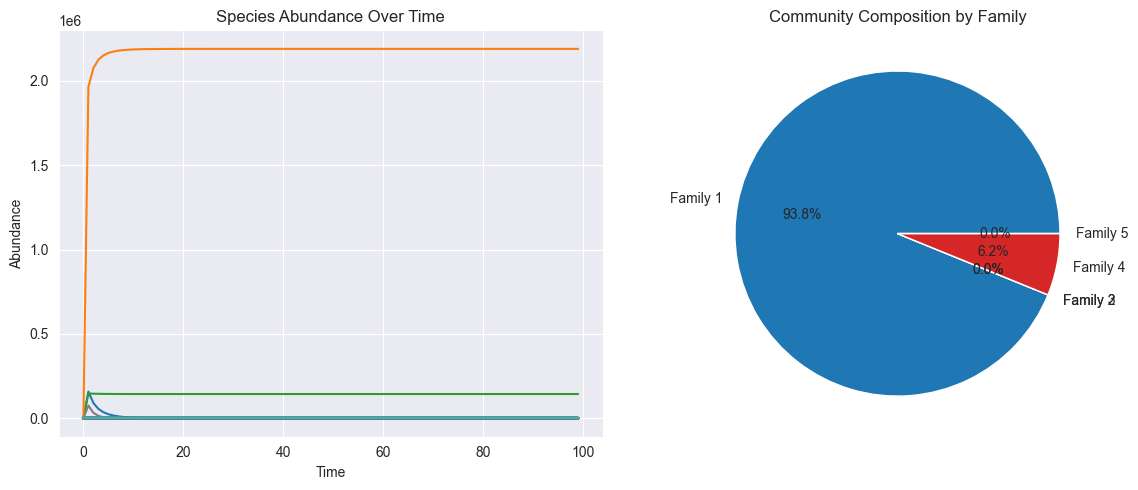

In [4]:
# Plot species abundance over time
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(result['species'])
axs[0].set_title("Species Abundance Over Time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Abundance")

# Plot coarse-grained community structure
final_abundance = result['communityStruct']
x = coarse_grain_community_structure(final_abundance, group_labels, numGroups)
x[x < 1e-10] = 0
axs[1].pie(x + 1e-20, labels=[f"Family {i+1}" for i in range(numGroups)], autopct='%1.1f%%')
axs[1].set_title("Community Composition by Family")

plt.tight_layout()
plt.show()

## Get diversity measures

In [5]:
diversity = alpha_diversity(result['communityStruct'])
print(diversity['Shannon'])


0.23116491903325767


Here, I perform parameter sweep over secretion strength to investigate how cross-feeding intensity (metabolic leakage) influences microbial community diversity. Using a consumer-resource model, the script varies the scale of the secretion matrix D, simulates community dynamics, and records Shannon diversity and species richness for each condition. This helps quantify the ecological impact of cross-feeding on community assembly.

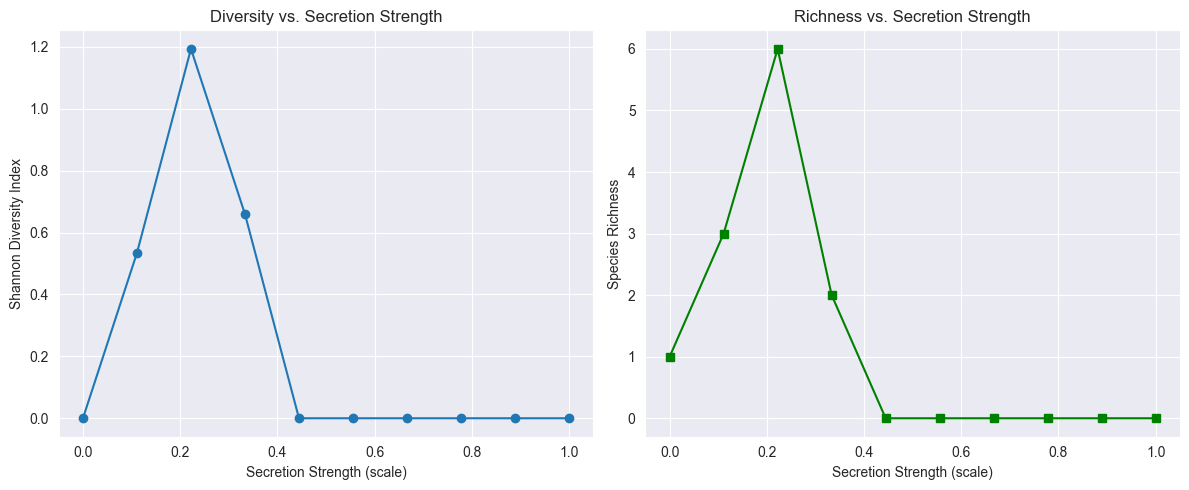

In [6]:
# Sweep settings
secretion_strengths = np.linspace(0.0, 1, 10)  # Create a range of 10 secretion strengths from 0 (no cross-feeding) to 1 (full leakage)
shannon_list = []                             # Initialize list to store Shannon diversity for each simulation
richness_list = []                            # Initialize list to store species richness for each simulation

# Fixed model parameters
Total_Number_Of_Species = 1000                # Global species pool size
numSpecies = 100                              # Number of species to sample into each local community
numGroups = 5                                 # Number of metabolic families for trait priors
numResources = 5                              # Number of resources in the environment
Total = 100                                   # Dirichlet strength (total weight) for generating consumption vectors
specialist = 0.5                              # Degree of specialization (fraction of preference allocated to preferred resource)
specialistVar = 0.01                          # Variation in specialization among species
resourceIdx = 1                               # Index of the externally supplied resource

# Begin sweep
for scale in secretion_strengths:             # Loop over each secretion strength value
    # Generate secretion matrix D
    D = get_metabolism(numResources, 'rand', scale)  # Create a random secretion matrix with the current scale
    
    # Generate priors and consumer matrix
    priors = [get_consumer_priors(100, i, specialist, specialistVar, numResources).T 
              for i in range(numGroups)]             # Generate metabolic priors for each family
    out, _ = make_phylo_consumers(                   # Create consumers using priors and sample from trait families
        Total_Number_Of_Species,
        numResources,
        numGroups,
        priors,
        Total,
        True
    )

    # Randomly select a community
    k = np.random.choice(Total_Number_Of_Species, numSpecies, replace=False)  # Randomly pick species for the community
    C_sampled = out['C'][k, :]                       # Extract the corresponding consumption matrix
    group_sampled = np.array(out['group'])[k]       # Extract the group labels for selected species

    # Initialize model parameters
    params = mcrm_params(                            # Create parameters for CRM simulation
        resourceIdx,                                 # Index of supplied resource
        numSpecies,                                  # Number of species in the local community
        C_sampled,                                   # Consumption matrix
        D,                                           # Secretion matrix
        'eye',                                       # Use identity matrix for shared resource qualities
        W_mode='shared'                              # All species share the same quality values (W)
    )
    
    # Run CRM simulation
    result = run_mcrm(params)                        # Simulate species-resource dynamics over time
    final_abundances = result['communityStruct']     # Get the final species abundances at equilibrium
    
    # Calculate diversity metrics
    diversity = alpha_diversity(result['communityStruct'])  # Compute alpha diversity metrics
    shannon = diversity['Shannon']                   # Extract Shannon diversity index
    richness = diversity['Richness']                 # Extract species richness (number of surviving species)
    
    # Store metrics
    shannon_list.append(shannon)                     # Save Shannon index to list
    richness_list.append(richness)                   # Save richness to list

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(secretion_strengths, shannon_list, marker='o')
ax[0].set_xlabel('Secretion Strength (scale)')
ax[0].set_ylabel('Shannon Diversity Index')
ax[0].set_title('Diversity vs. Secretion Strength')

ax[1].plot(secretion_strengths, richness_list, marker='s', color='green')
ax[1].set_xlabel('Secretion Strength (scale)')
ax[1].set_ylabel('Species Richness')
ax[1].set_title('Richness vs. Secretion Strength')

plt.tight_layout()
plt.show()

Here, we simulate microbial community assembly across multiple replicates with varying single-resource supply to investigate how environmental filtering drives functional convergence. Although each replicate samples a random subset of species from a diverse metabolic pool, only those with sufficient uptake capacity for the supplied resource consistently survive. This selective pressure leads to convergence in functional traits - such as total uptake and specialization - despite variability in species identity, mirroring Goldford et al.’s findings on functional redundancy and ecological filtering in microbial ecosystems.

In [7]:
num_resources = 3         # Number of distinct resources to simulate (supply 1 at a time)
num_groups = 4            # Number of metabolic families for consumer trait generation
total_species = 1000      # Size of the global species pool
subset_size = 50          # Number of species sampled into each simulated community
replicates = 20           # Number of replicate simulations per resource
Total = 100               # Total weight of the Dirichlet distribution (controls trait concentration)
numResource = 10          # Total number of resource types considered in the C and D matrices
specialist = 0.5          # Fraction of total uptake dedicated to one preferred resource
specialistVariation = 0.01 # Variability in specialization level across species

# Generate global consumer pool from 4 metabolic families
priors = [
    get_consumer_priors(100, r, specialist, specialistVariation, numResource)
    for r in range(num_groups)
]  # Create Dirichlet priors for each family, biasing resource preference per group

out, _ = make_phylo_consumers(
    total_species, numResource, num_groups, priors, Total, non_normal=True
)  # Generate the full trait matrix C and group labels for all species

results = []  # Initialize a list to store simulation results

In [8]:
# Sweep through each resource being supplied
for resource_idx in range(num_resources):  # Iterate over 3 supplied resources (index 0, 1, 2)
    for _ in range(replicates):            # Repeat the simulation 20 times per resource
        
        # Sample a community
        k = np.random.choice(total_species, subset_size, replace=False)  # Randomly select species
        C_sample = out['C'][k]                      # Get the consumption matrix for selected species
        group_labels = out['group'][k]              # Get corresponding group (family) labels
        
        # Simulate growth on resource `resource_idx`
        D = get_metabolism(numResource, 'rand', 1/numResource)  # Generate random secretion matrix with moderate leakage
        params = mcrm_params(
            resource_idx, subset_size, C_sample, D, qual='eye'
        )  # Create model parameters, using shared resource quality identity matrix
        
        result = run_mcrm(params)  # Run the CRM simulation for this community
        
        # Save result with group labels and supplied resource index
        results.append({
            'species_abundance': result['communityStruct'],          # Final species abundances
            'resource_abundance': result['environmentalStruct'],     # Final resource concentrations
            'group_labels': group_labels,                            # Metabolic group of each species
            'resource_idx': resource_idx,                            # Which resource was supplied in this run
            'uptake_capacity': np.sum(C_sample @ result['environmentalStruct']),  # Total uptake flux across species
            'C_sample': C_sample                                     # Save C matrix for future use
        })

In [9]:
for r in results:
    surviving = r['species_abundance'] > 1e-16
    growth_support = np.sum(r['C_sample'][surviving], axis=1)
    print("Min support for surviving species:", np.min(growth_support))

Min support for surviving species: 0.9991837230426925
Min support for surviving species: 0.9915252834919575
Min support for surviving species: 0.9775240393913559
Min support for surviving species: 0.9949427833217659
Min support for surviving species: 1.002669924748579
Min support for surviving species: 0.9935128636683364
Min support for surviving species: 0.9947099908069206
Min support for surviving species: 0.9947730436599671
Min support for surviving species: 0.9934657897246891
Min support for surviving species: 0.9994750811657597
Min support for surviving species: 0.9939335339690024
Min support for surviving species: 0.988417430556812
Min support for surviving species: 0.984403353858869
Min support for surviving species: 0.9911266060431959
Min support for surviving species: 0.9911266060431959
Min support for surviving species: 0.9911266060431959
Min support for surviving species: 0.9999036239654093
Min support for surviving species: 0.9900959527617955
Min support for surviving speci

/var/folders/70/4lfklr4n6c5c6t79k1pf_3xh0000gr/T/ipykernel_44451/42565454.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


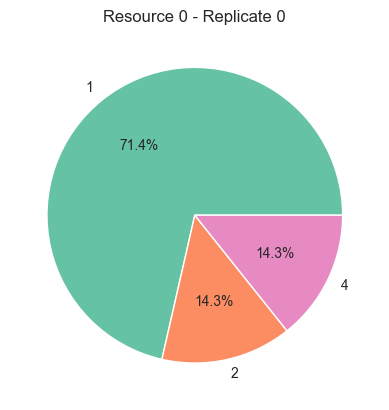

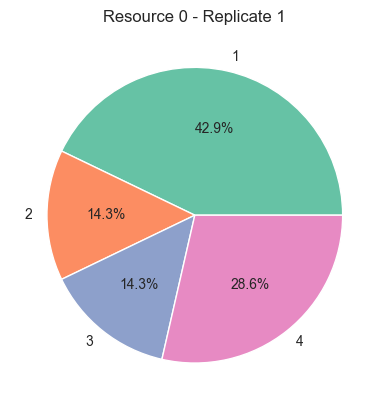

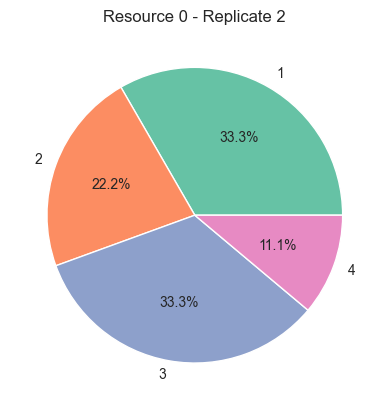

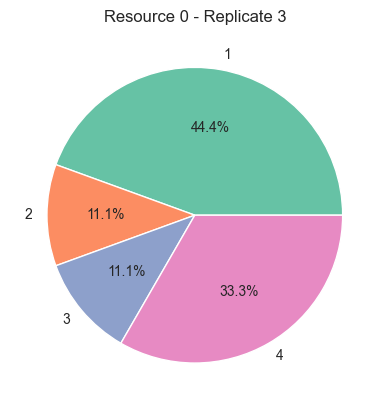

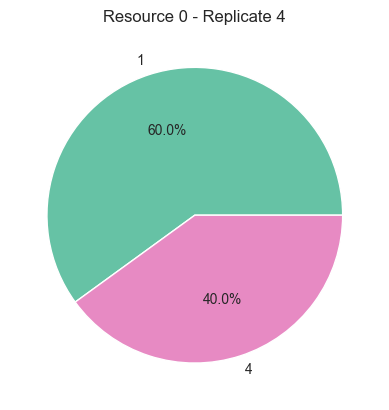

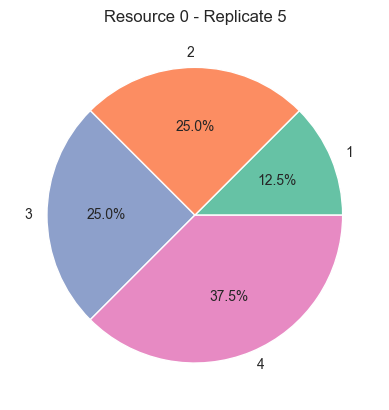

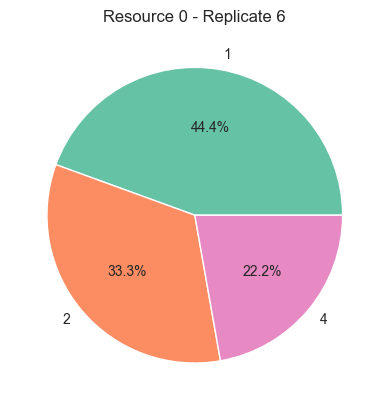

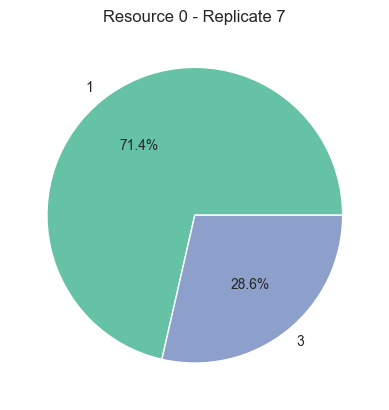

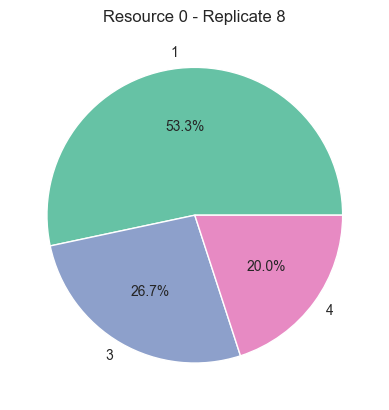

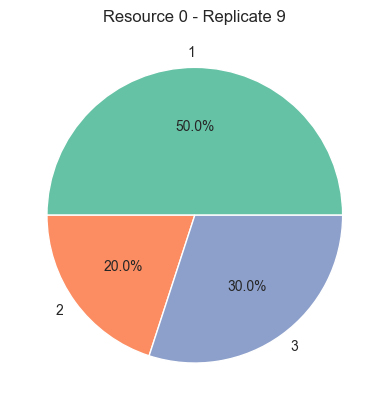

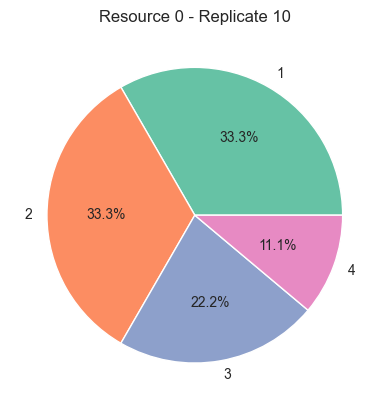

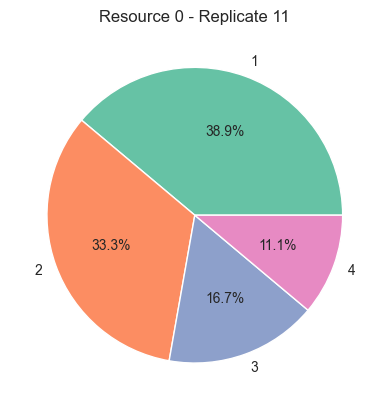

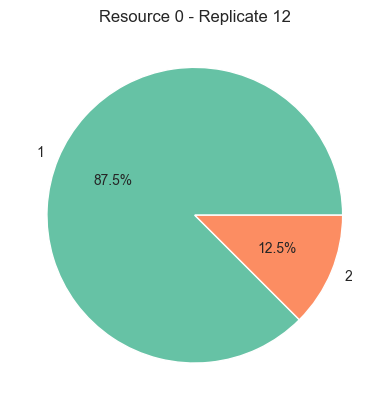

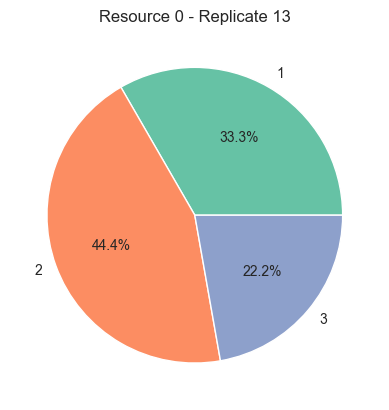

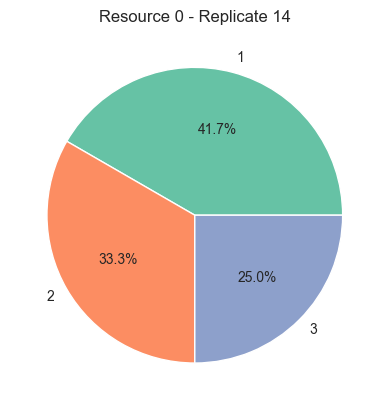

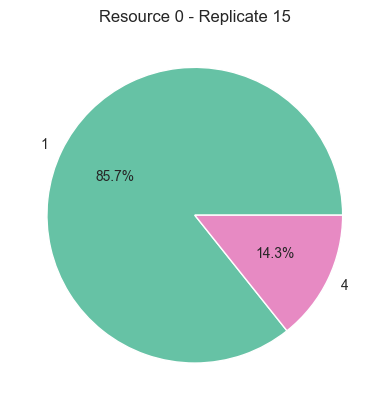

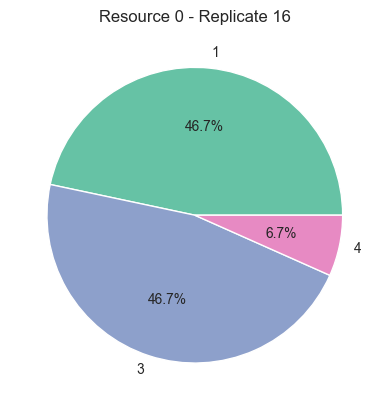

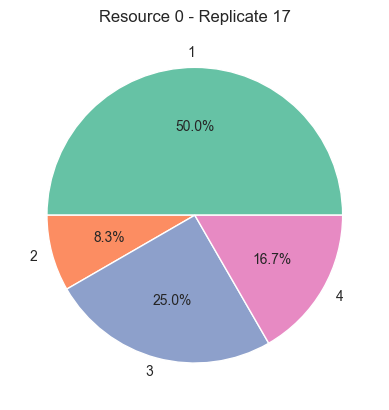

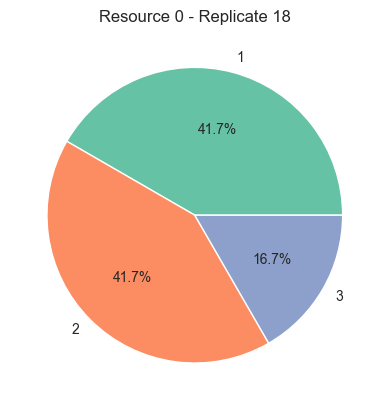

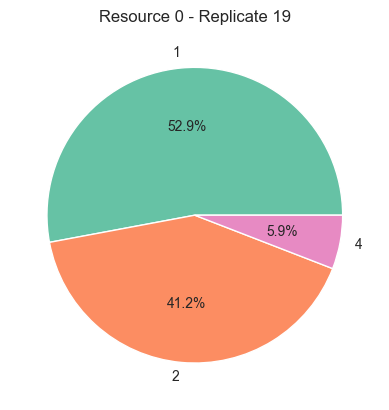

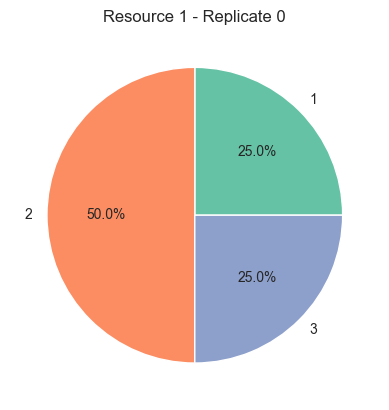

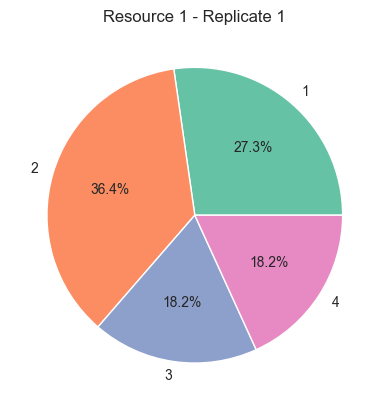

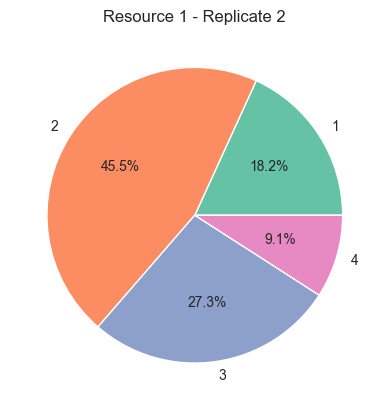

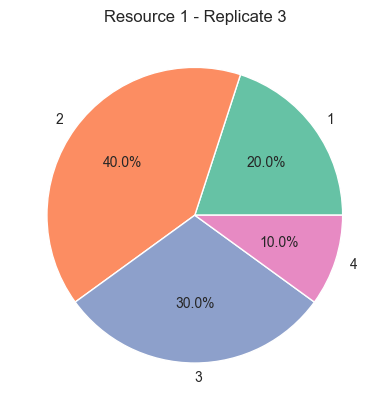

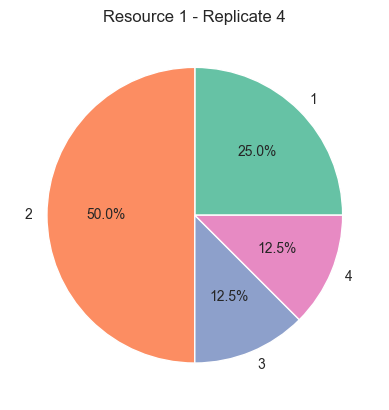

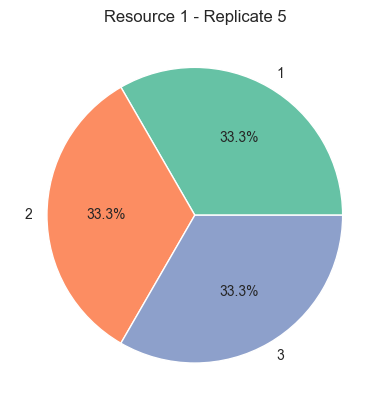

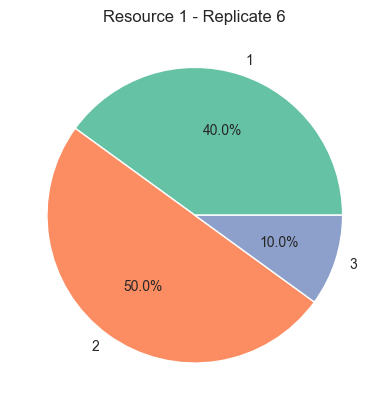

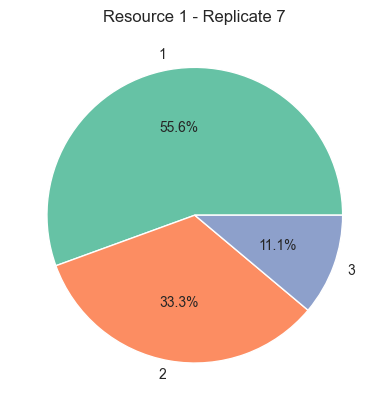

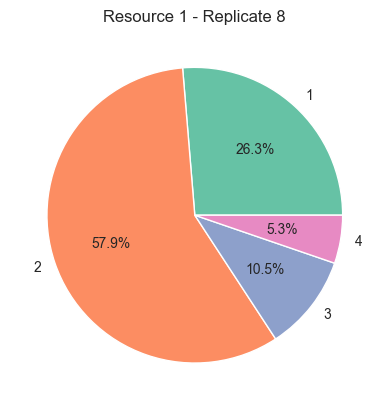

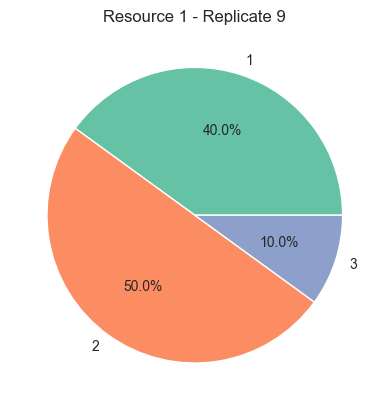

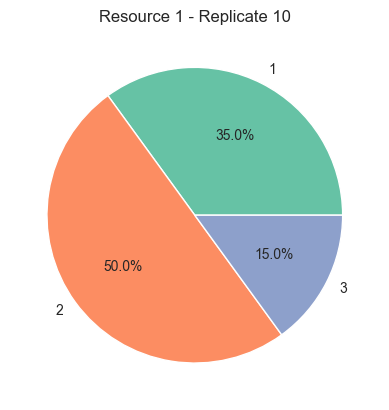

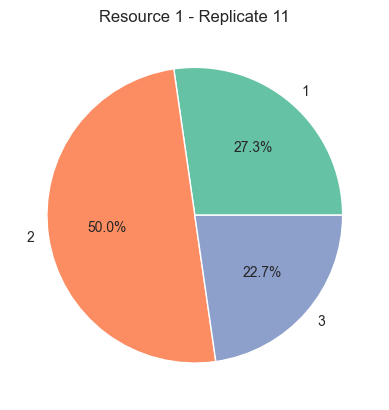

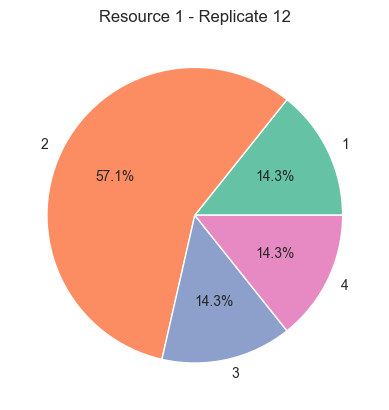

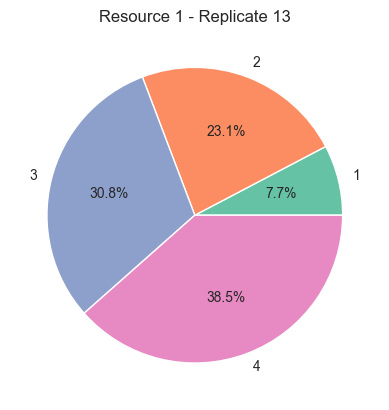

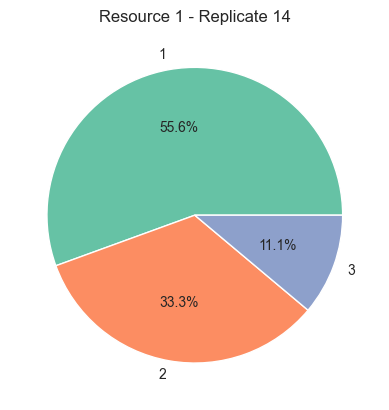

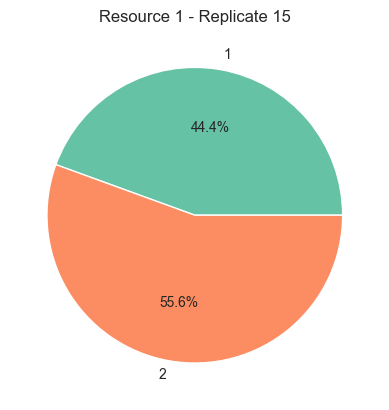

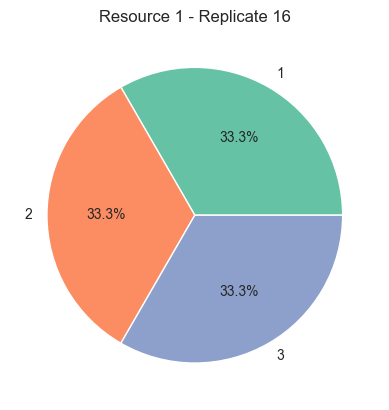

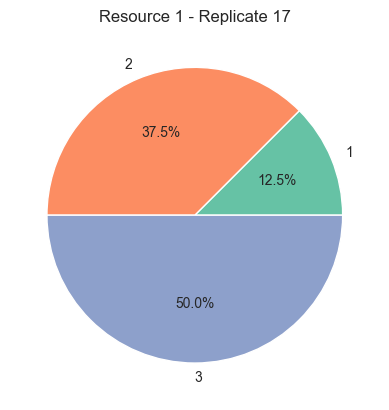

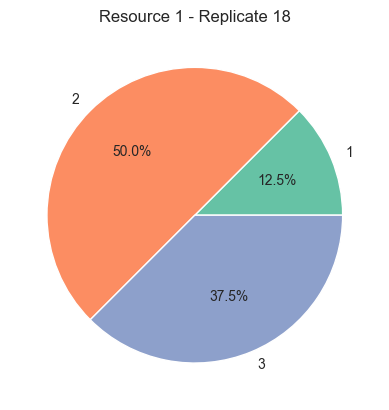

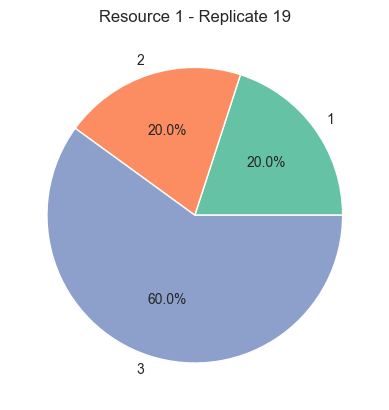

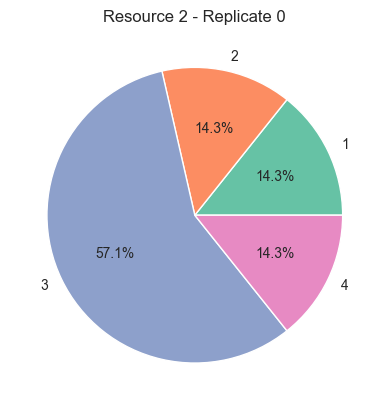

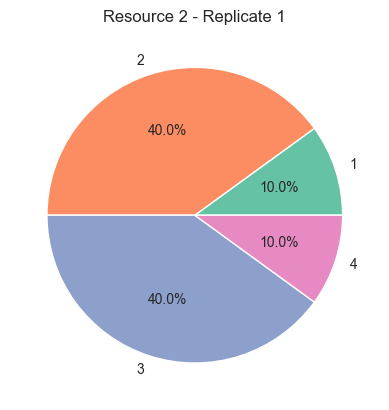

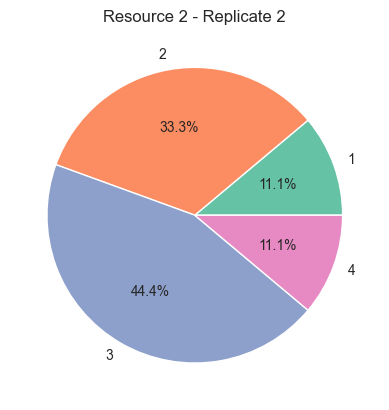

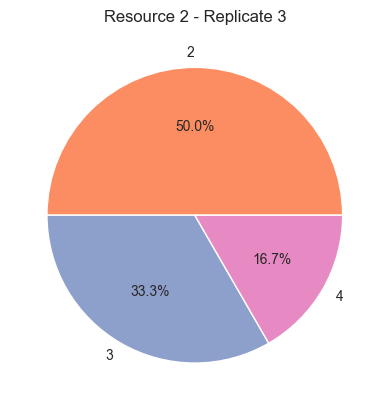

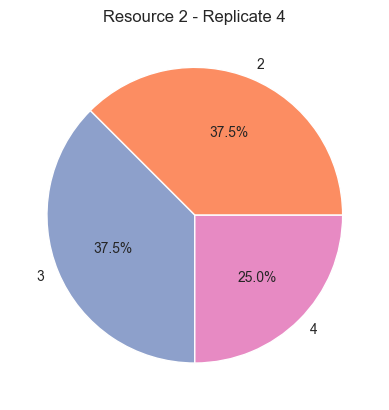

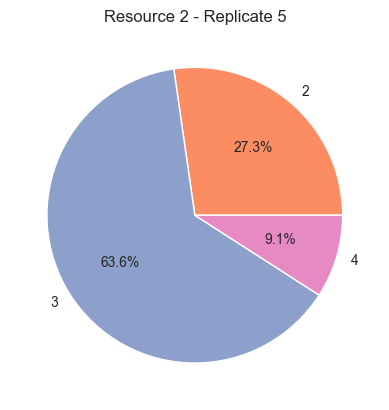

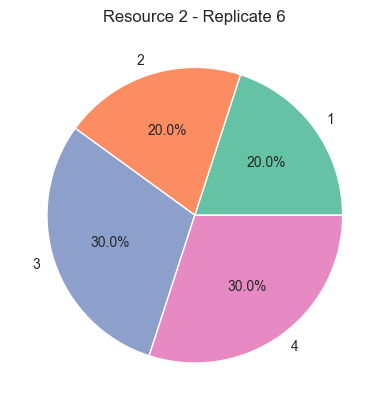

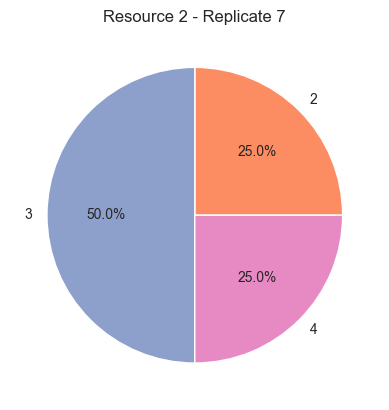

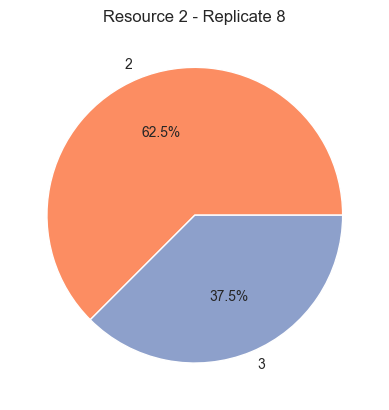

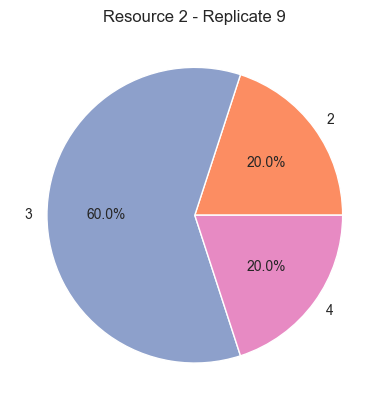

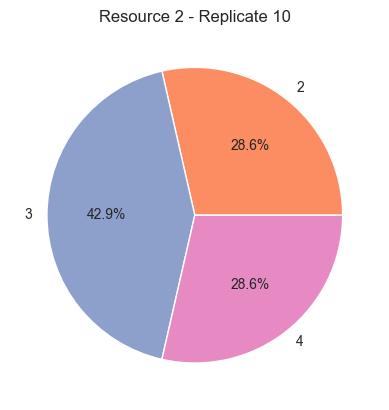

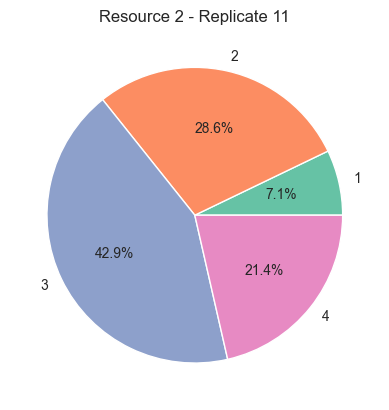

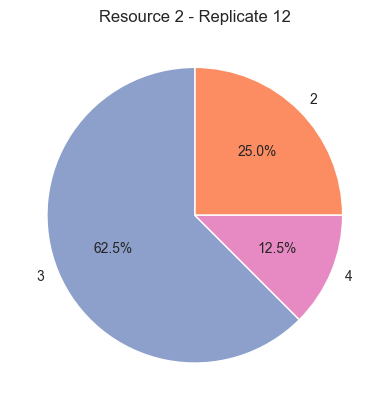

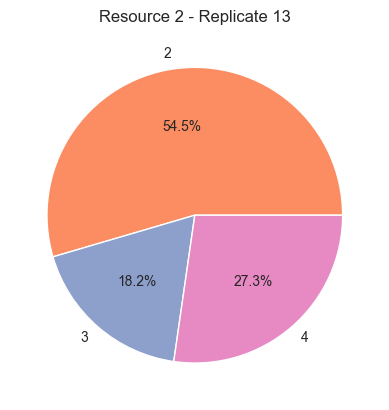

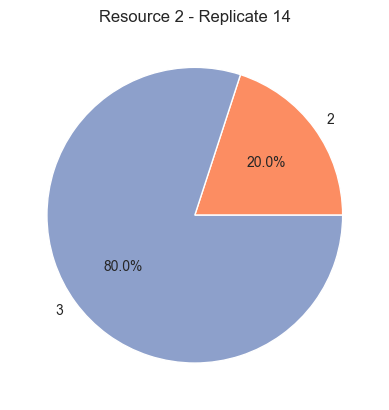

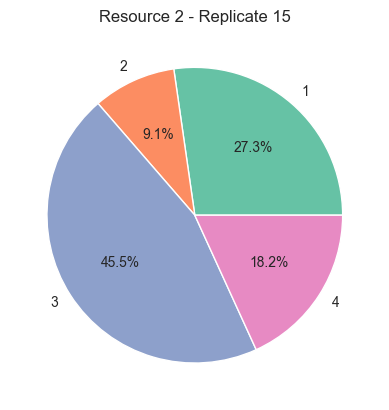

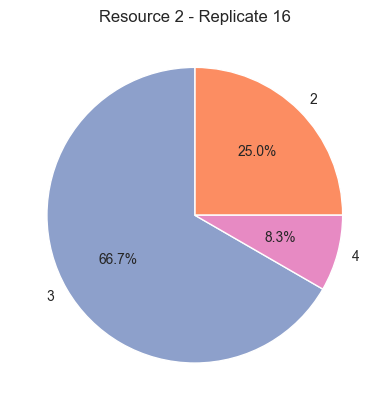

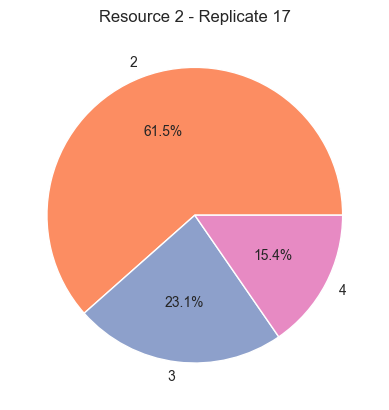

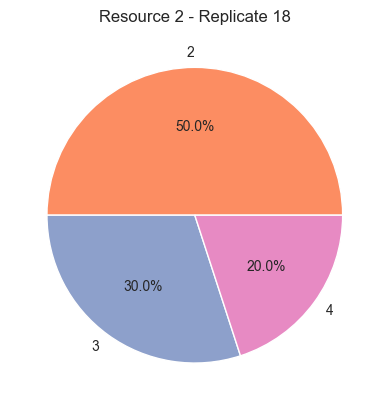

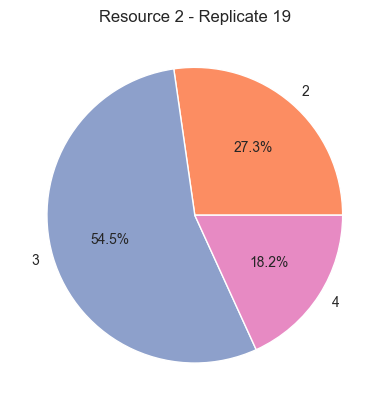

In [10]:
# Define fixed colors for families 1 to 4 (adjust if your group labels differ)
family_labels = sorted(set(r['group_labels'][0] for r in results))
palette = sns.color_palette("Set2", len(family_labels))  
family_color_map = {label: color for label, color in zip(family_labels, palette)}

for i, r in enumerate(results):
    surviving = r['species_abundance'] > 1e-20
    family_series = pd.Series(r['group_labels'][surviving])

    # Count the number of survivors per family
    family_counts = family_series.value_counts().sort_index()

    # Match the color order to family labels
    colors = [family_color_map[label] for label in family_counts.index]

    # Plot pie chart
    plt.figure()
    family_counts.plot.pie(autopct='%1.1f%%', colors=colors)
    plt.title(f"Resource {r['resource_idx']} - Replicate {i % replicates}")
    plt.ylabel('')  # Hide y-label for aesthetics

This plot below compares the community-wide uptake capacity across different supplied resources to assess whether functional convergence occurs. By visualizing the distribution of total resource uptake for each resource index using a boxplot, we can evaluate whether communities consistently achieve similar functional outcomes when supplied with the same resource. For example, if the box for a given resource is narrow and centered around a high median, it suggests that most communities, regardless of species composition, perform similarly—indicating functional convergence. In contrast, a wide or low-distribution box may reveal variability or limitations in functional potential, implying that the identity of the supplied resource influences overall performance. This analysis helps determine the extent to which microbial communities can buffer ecological differences and maintain ecosystem function under varying resource inputs.

Text(0.5, 1.0, 'Functional Convergence by Supplied Resource')

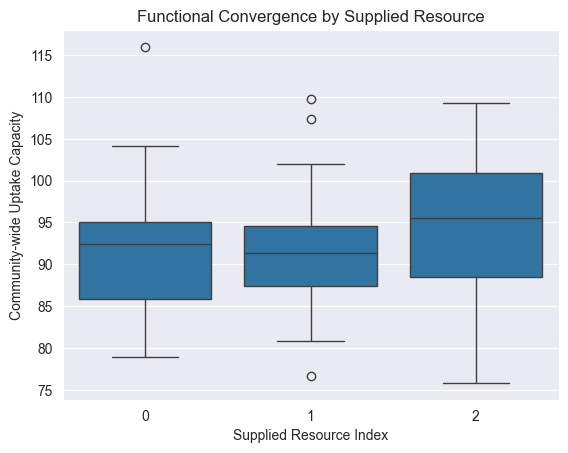

In [13]:
df = pd.DataFrame(results)
sns.boxplot(data=df, x='resource_idx', y='uptake_capacity')
plt.xlabel("Supplied Resource Index")
plt.ylabel("Community-wide Uptake Capacity")
plt.title("Functional Convergence by Supplied Resource")

This code generates heatmaps that visualize different aspects of microbial community assembly outcomes from simulation results. First, it collects species-level abundances, aggregates them by metabolic families, and computes community-wide uptake capacities across all simulations. The first heatmap displays species abundances across simulations, allowing us to observe patterns such as dominance, extinction, or coexistence. The second heatmap shows how those species-level dynamics translate into metabolic family-level structures—revealing whether specific families consistently dominate across resource types or replicates. The third heatmap illustrates the community’s ability to utilize available resources by showing uptake capacities for each resource across simulations. Together, these visualizations allow us to examine ecological patterns like functional redundancy, trait filtering, and convergence or divergence in community function, depending on which resource is supplied or how communities are assembled. For example, uniform family patterns might suggest strong trait filtering, while diverse uptake profiles might point to niche differentiation or metabolic flexibility.

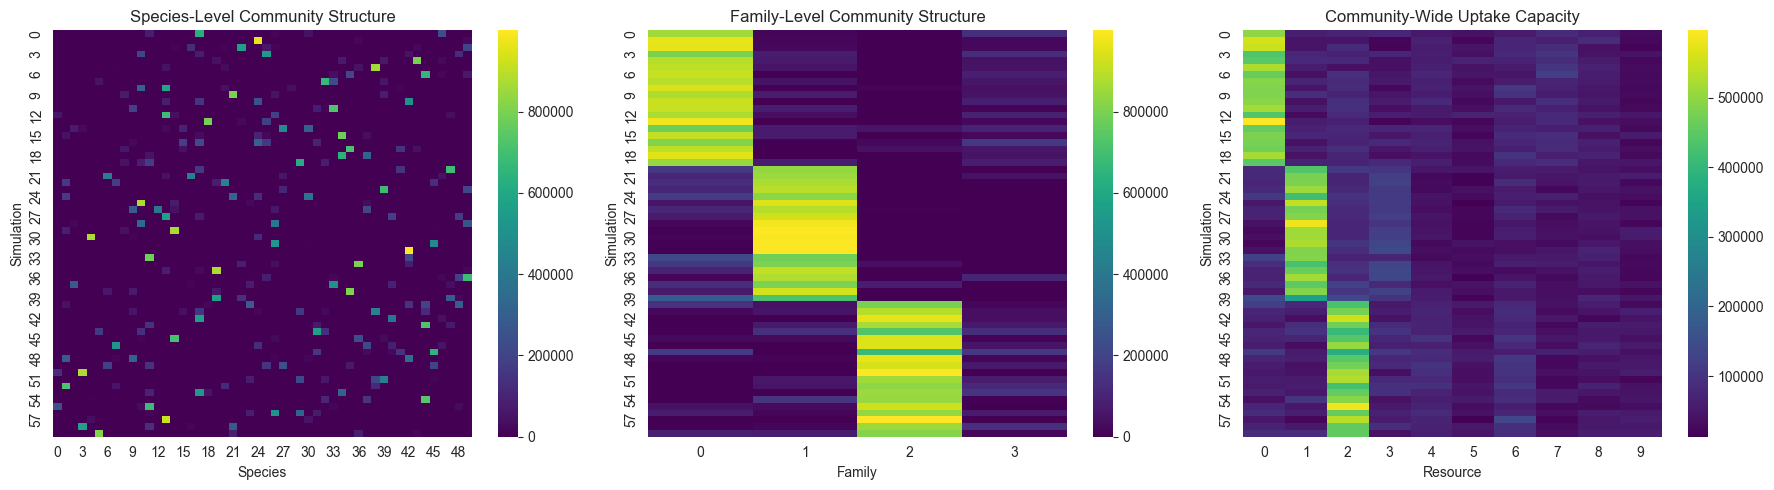

In [60]:
# Initialize storage
species_structures = []
family_structures = []
uptake_capacities = []

# Determine number of metabolic families
num_families = max(np.max(r['group_labels']) for r in results)

# Extract data from results
for r in results:
    species_structures.append(r['species_abundance'])

    # Aggregate abundances at the family level
    fam_vec = np.zeros(num_families)
    for f in range(1, num_families + 1):
        fam_vec[f - 1] = r['species_abundance'][r['group_labels'] == f].sum()
    family_structures.append(fam_vec)

    # Compute community-wide uptake capacity per resource
    uptake = r['C_sample'].T @ r['species_abundance']
    uptake_capacities.append(uptake)

# Convert lists to arrays
species_structures = np.array(species_structures)
family_structures = np.array(family_structures)
uptake_capacities = np.array(uptake_capacities)

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(species_structures, ax=axes[0], cmap='viridis')
axes[0].set_title('Species-Level Community Structure')
axes[0].set_xlabel('Species')
axes[0].set_ylabel('Simulation')

sns.heatmap(family_structures, ax=axes[1], cmap='viridis')
axes[1].set_title('Family-Level Community Structure')
axes[1].set_xlabel('Family')
axes[1].set_ylabel('Simulation')

sns.heatmap(uptake_capacities, ax=axes[2], cmap='viridis')
axes[2].set_title('Community-Wide Uptake Capacity')
axes[2].set_xlabel('Resource')
axes[2].set_ylabel('Simulation')

plt.tight_layout()
plt.show()